# Schrodinger's Equation

## References -- move to bottom
* Atkins & Friedman (Molecular Quantum Mechanics textbook)
* Barba, Lorena A., et al. "MAE 6286 Practical Numerical Methods with Python." The George Washington University. http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about. 2014
* http://arxiv.org/pdf/0704.3240.pdf

Wave functions are used in quantum mechanics to describe the position of a particle at a certain time. The fundamental equation used to solve these wave functions is the Schrodinger equation. 

\begin{equation}
i\hbar\frac{\partial}{\partial t}\psi(x, t) = -\frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2}\psi(x, t)
\end{equation}

Discretized Equation:

\begin{eqnarray}
i\hbar\frac{\psi^{n+1}_i - \psi^n_i}{\Delta t} = \frac{\hbar^2}{2m} \cdot \frac{1}{2} &\left( 
\frac{\psi^{n+1}_{i+1} - 2\psi^{n+1}_i + \psi^{n+1}_{i-1}}{\Delta x^2} 
+ \frac{\psi^n_{i+1}-2\psi^n_i + \psi^n_{i-1}}{\Delta x^2}
\right)
\end{eqnarray}

In [173]:
import numpy
from scipy.linalg import solve
from scipy.interpolate import spline
from matplotlib import pyplot
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [174]:
def generateMatrix(N, sigma):
   
    ##We need a TRIDIAGONAL MATRIX!!

    # Set Diagonalfrom discritization
    d = numpy.diag(numpy.ones(N-2)*(1+2j/sigma))
       
    # Set Upper Diagonal
    ud = numpy.diag(numpy.ones(N-3)*-1, 1)
    #ud = numpy.diag(numpy.zeros(N-3),1)
    
    # Set Lower Diagonal
    ld = numpy.diag(numpy.ones(N-3)*-1, -1)
    #ld = numpy.diag(numpy.zeros(N-3),-1)
    
    A = d + ud + ld
    
    return A                   

In [175]:
#This is what we know

def genRHS(psi, sigma): 
    
    x = psi[1:-1]*((2j/sigma)+1) + psi[:-2] + psi[2:]
    
    #Dirichlet boundary conditions
    x[0] += psi[0]
    x[-1] += psi[0]
    
    return x

In [176]:
def CrankNicolson(psi, A, nt, sigma):
    
    for t in range(nt):
        psi_n = psi.copy()
        x = genRHS(psi_n, sigma)
        
        psi_inside = solve(A, x)
        psi[1:-1] = psi_inside
        
    return psi

In [177]:
L = 1
nx = 21 #21

h = 6.62607004e-34 #[m^2*kg/s]
hbar = h/(2*numpy.pi)
m = 6.6464764063e-27 #[kg] - mass of Helium ion
dx = L/(nx-1)


psi_i = numpy.zeros(nx, dtype = numpy.complex)
psi_i[0] = 1

sigma = 0.5 #0.5
dt = sigma*(dx**2)*m/hbar
nt = 10

A = generateMatrix(nx, sigma)

print(dt)

78781.69610432451


In [188]:
#print(A)

In [179]:
psi = CrankNicolson(psi_i.copy(), A, nt, sigma)

print(psi)

[  1.00000000e+00 +0.00000000e+00j  -3.81617326e-01 -2.46051740e+00j
  -3.10078891e+00 -4.88926654e-01j  -1.20641729e+00 +2.09563726e+00j
   7.69494258e-01 +8.80587809e-01j   3.40226224e-01 -1.51222102e-01j
  -1.10361424e-02 -7.90944193e-02j  -1.13976084e-02 -1.46000962e-03j
  -4.00038904e-04 +9.89864360e-04j   4.67907864e-05 +3.44041914e-05j
   1.62712546e-06 -1.34787313e-06j   2.33953932e-05 +1.72020957e-05j
  -2.00019452e-04 +4.94932180e-04j  -5.69880421e-03 -7.30004808e-04j
  -5.51807118e-03 -3.95472096e-02j   1.70113112e-01 -7.56110509e-02j
   3.84747129e-01 +4.40293905e-01j  -6.03208645e-01 +1.04781863e+00j
  -1.55039446e+00 -2.44463327e-01j  -1.90808663e-01 -1.23025870e+00j
   0.00000000e+00 +0.00000000e+00j]


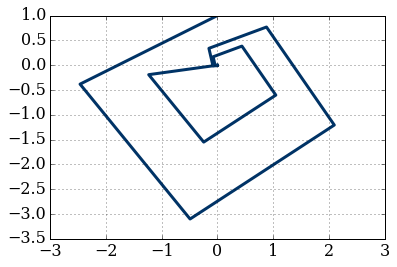

In [180]:
x = numpy.linspace(0,L,nx)

pyplot.plot(psi.imag, psi.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)

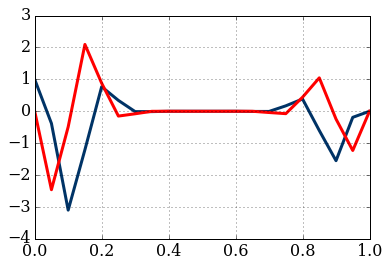

In [181]:
pyplot.plot(x, psi.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)
pyplot.plot(x, psi.imag, color='r', ls='-', lw=3);
pyplot.grid(True)

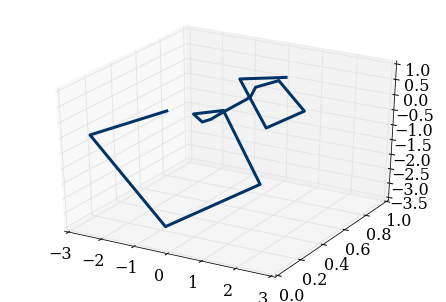

In [182]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.view_init()

ax.plot(psi.imag, x, psi.real, color = '#003366', lw =3)


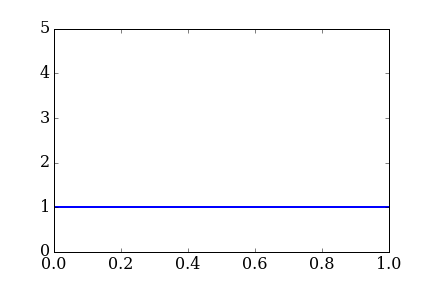
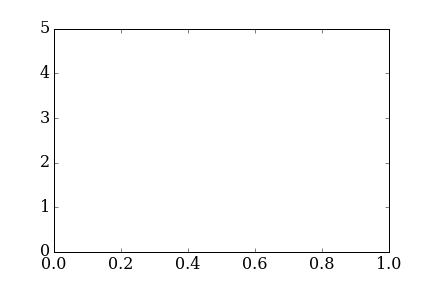
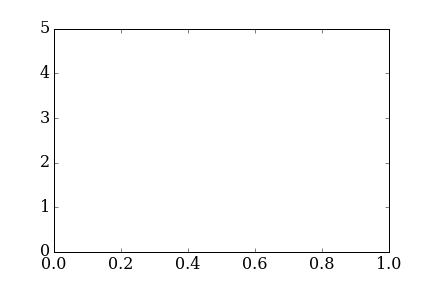
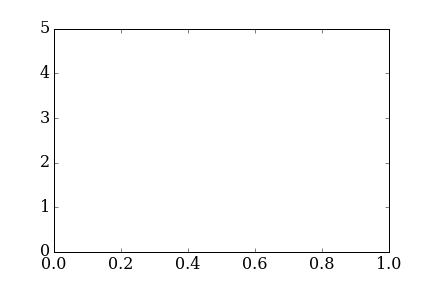
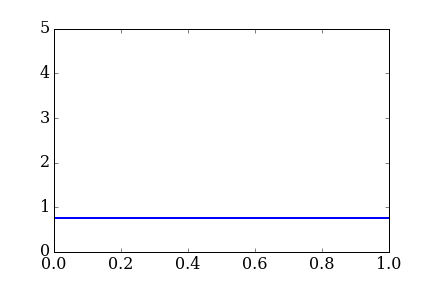
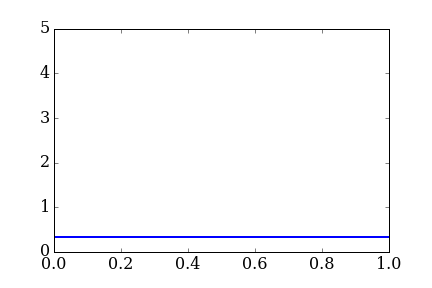
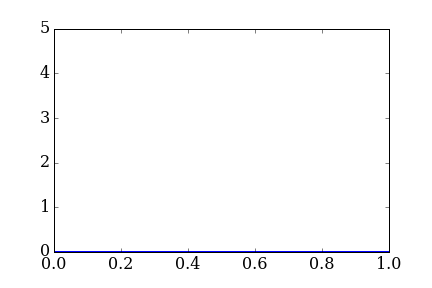
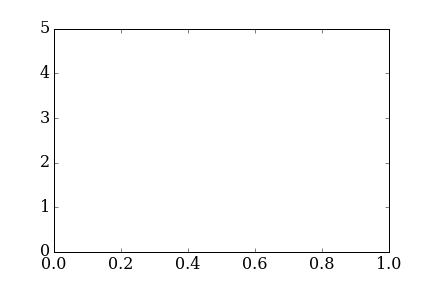
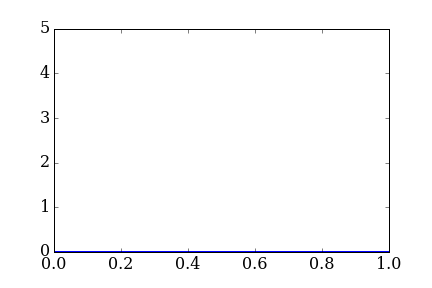
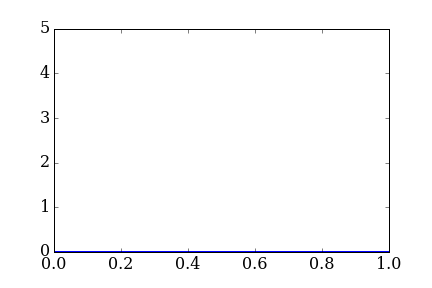
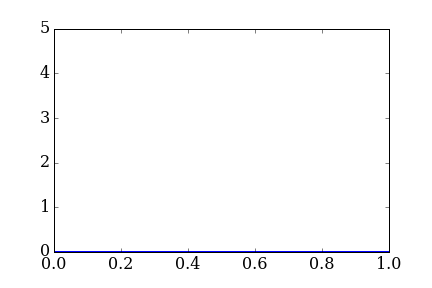
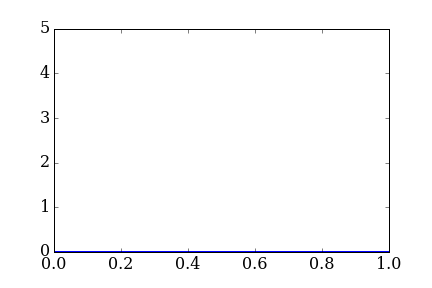
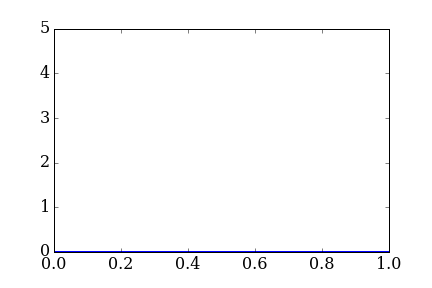
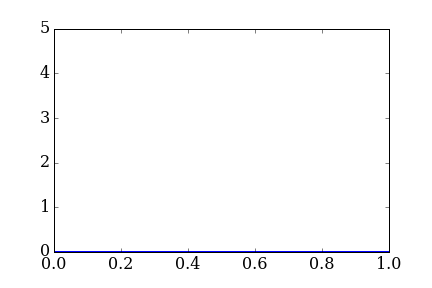
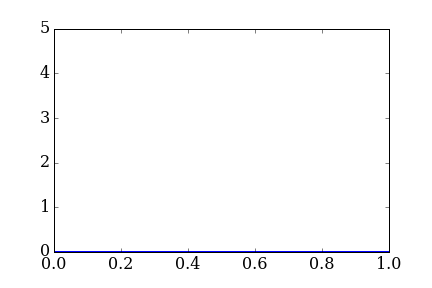
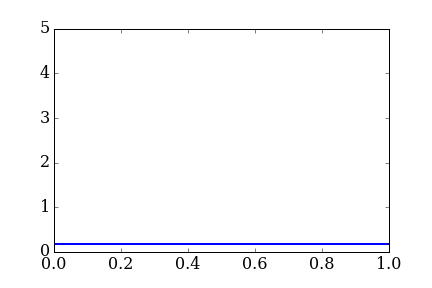
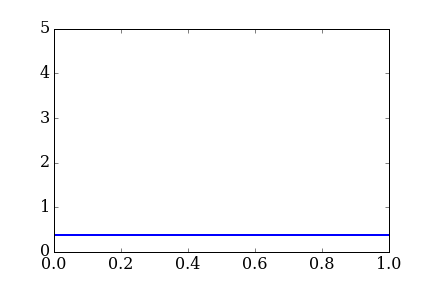
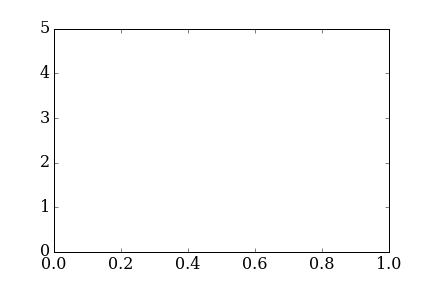
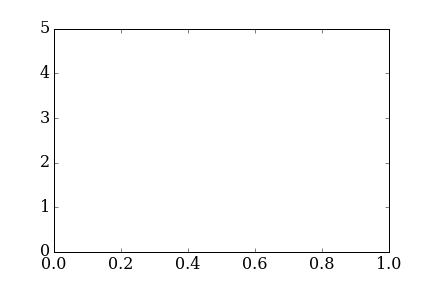
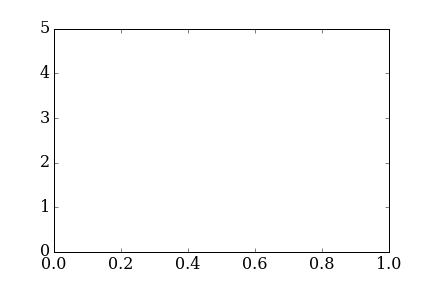
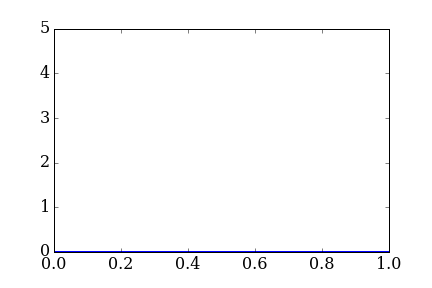

In [183]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

fig = pyplot.figure();
ax = pyplot.axes(xlim = (0,L), ylim = (0,5))
line, = ax.plot([],[],lw = 2)

def animate(data):
    x = numpy.linspace(0, L, nx)
    y = data
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames = psi.real, interval = 50)

display_animation(anim, default_mode = 'once')


In [184]:
psi_conj = numpy.conj(psi)
probfunc = psi_conj*psi

#print(psi_conj)
#print()
print(probfunc)
probfunc_real = probfunc.real
print(probfunc_real)

[  1.00000000e+00+0.j   6.19977766e+00+0.j   9.85394116e+00+0.j
   5.84713822e+00+0.j   1.36755630e+00+0.j   1.38622008e-01+0.j
   6.37772360e-03+0.j   1.32037106e-04+0.j   1.13986258e-06+0.j
   3.37302608e-09+0.j   4.46429922e-12+0.j   8.43256520e-10+0.j
   2.84965644e-07+0.j   3.30092765e-05+0.j   1.59443090e-03+0.j
   3.46555019e-02+0.j   3.41889076e-01+0.j   1.46178456e+00+0.j
   2.46348529e+00+0.j   1.54994441e+00+0.j   0.00000000e+00+0.j]
[  1.00000000e+00   6.19977766e+00   9.85394116e+00   5.84713822e+00
   1.36755630e+00   1.38622008e-01   6.37772360e-03   1.32037106e-04
   1.13986258e-06   3.37302608e-09   4.46429922e-12   8.43256520e-10
   2.84965644e-07   3.30092765e-05   1.59443090e-03   3.46555019e-02
   3.41889076e-01   1.46178456e+00   2.46348529e+00   1.54994441e+00
   0.00000000e+00]


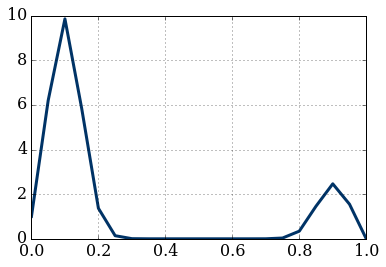

In [185]:
pyplot.plot(x, probfunc_real, color='#003366', ls='-', lw=3);
pyplot.grid(True)


In [161]:
def psi_analytical(x, t, n_max, h, m, L, hbar):
    
    psi = 0
    for n in range (1, n_max+1):
        
        E = ((n**2)*(h**2))/(8*m*(L**2))
        
        summation = numpy.sqrt(2/L)*numpy.sin(n*numpy.pi*x/L)*numpy.exp(-1j*E*t/hbar)
        psi+= summation
        
    return psi


In [162]:
psi_analytical = psi_analytical(x, dt*nt, 1, h, m, L, hbar)
print(psi_analytical)

[  0.00000000e+00 +0.00000000e+00j   2.20810977e-01 -1.36380334e-02j
   4.36184856e-01 -2.69402531e-02j   6.40818415e-01 -3.95791144e-02j
   8.29672899e-01 -5.12434065e-02j   9.98098082e-01 -6.16459159e-02j
   1.14194678e+00 -7.05304983e-02j   1.25767695e+00 -7.76783857e-02j
   1.34243895e+00 -8.29135735e-02j   1.39414564e+00 -8.61071539e-02j
   1.41152384e+00 -8.71804904e-02j   1.39414564e+00 -8.61071539e-02j
   1.34243895e+00 -8.29135735e-02j   1.25767695e+00 -7.76783857e-02j
   1.14194678e+00 -7.05304983e-02j   9.98098082e-01 -6.16459159e-02j
   8.29672899e-01 -5.12434065e-02j   6.40818415e-01 -3.95791144e-02j
   4.36184856e-01 -2.69402531e-02j   2.20810977e-01 -1.36380334e-02j
   1.72861816e-16 -1.06765308e-17j]


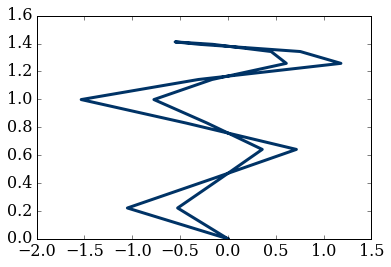

In [163]:
pyplot.plot(psi.imag, psi_analytical.real, color = '#003366', ls = '-', lw =3)

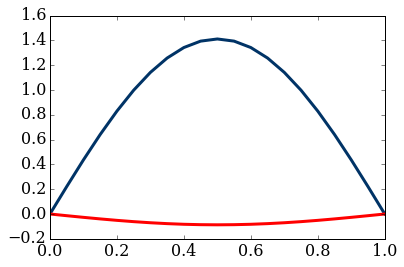

In [164]:
pyplot.plot(x, psi_analytical.real, color = '#003366', ls = '-', lw =3)
pyplot.plot(x, psi_analytical.imag, color = 'r', ls = '-', lw =3)

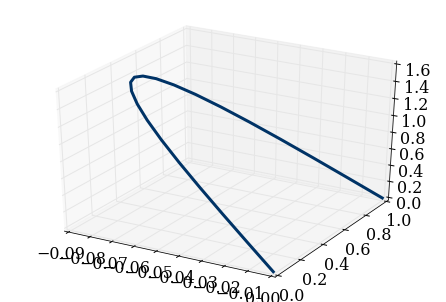

In [165]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.view_init()

ax.plot(psi_analytical.imag, x, psi_analytical.real, color = '#003366', lw =3)

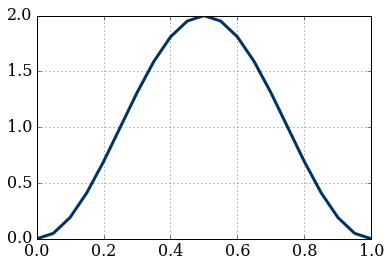

In [166]:
probfunc_analytical = numpy.conj(psi_analytical)*psi_analytical
pyplot.plot(x, probfunc_analytical.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)